## Problem Description
Insurance companies take risks over customers. Risk management is a very important aspect of the insurance industry. Insurers consider every quantifiable factor to develop profiles of high and low insurance risks. Insurers collect vast amounts of information about policyholders and analyze the data.

As a Data scientist in an insurance company, you need to analyze the available data and predict whether to sanction the insurance or not.

## Dataset Description
A zipped file containing train, test and sample submission files are given. The training dataset consists of data corresponding to 52310 customers and the test dataset consists of 22421 customers. Following are the features of the dataset

- Target: Claim Status (Claim)
- Name of agency (Agency)
- Type of travel insurance agencies (Agency.Type)
- Distribution channel of travel insurance agencies (Distribution.Channel)
- Name of the travel insurance products (Product.Name)
- Duration of travel (Duration)
- Destination of travel (Destination)
- Amount of sales of travel insurance policies (Net.Sales)
- The commission received for travel insurance agency (Commission)
- Age of insured (Age)
- The identification record of every observation (ID)

# Evaluation Metric
The evaluation metric for this task will be **precision_score**.

**=========================================Data Analaysis Begins=========================================**

### Importing Necessary Pacakages

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from seaborn_qqplot import pplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer

Defining path for data files

In [36]:
train_path='./train.csv'
test_path='./test.csv'

Loading data

In [37]:
df_train=pd.read_csv(train_path)
df_test=pd.read_csv(test_path)

Getting intution about data with head and describe

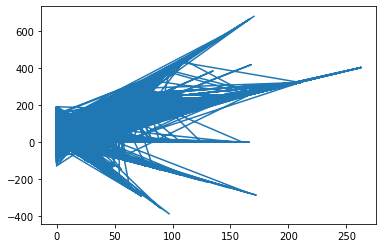

In [38]:
plt.plot(df_train['Commision (in value)'],df_train['Net Sales'])

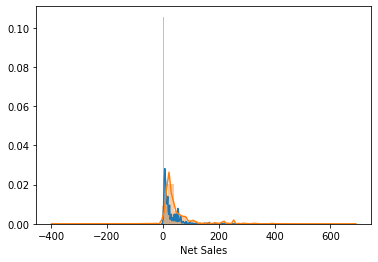

In [39]:
sns.distplot(df_train['Commision (in value)'],kde=True)
sns.distplot(df_train['Net Sales'])

In [42]:
df_test.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,17631,EPX,Travel Agency,Online,Cancellation Plan,192,HONG KONG,18.0,0.00,36
1,15064,EPX,Travel Agency,Online,1 way Comprehensive Plan,2,SINGAPORE,20.0,0.00,36
2,14139,C2B,Airlines,Online,Bronze Plan,13,SINGAPORE,13.5,3.38,24
3,19754,EPX,Travel Agency,Online,2 way Comprehensive Plan,133,"TAIWAN, PROVINCE OF CHINA",41.0,0.00,36
4,16439,C2B,Airlines,Online,Silver Plan,2,SINGAPORE,30.0,7.50,32


In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    52310 non-null  int64  
 1   Agency                52310 non-null  object 
 2   Agency Type           52310 non-null  object 
 3   Distribution Channel  52310 non-null  object 
 4   Product Name          52310 non-null  object 
 5   Duration              52310 non-null  int64  
 6   Destination           52310 non-null  object 
 7   Net Sales             52310 non-null  float64
 8   Commision (in value)  52310 non-null  float64
 9   Age                   52310 non-null  int64  
 10  Claim                 52310 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


Above summary shows no column has **"Null"** Values. We can also see there are 6 columns having numerical data and other are categorical data.

## Segregating Numerical and Object data

In [54]:
numerical_cols=df_train.select_dtypes(include=['int64','float64'])
categorical_cols=df_train.select_dtypes(include='object')

In [55]:
numerical_cols.columns

Index(['ID', 'Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Claim'], dtype='object')

In [56]:
df_train.describe()

,ID,Duration,Net Sales,Commision (in value),Age,Claim
count,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000
mean,6005.745804,58.256299,48.554673,12.219963,39.555725,0.166699
std,2306.450475,109.138606,60.198589,22.847645,13.762473,0.372710
min,2000.000000,0.000000,-389.000000,0.000000,0.000000,0.000000
25%,4015.000000,10.000000,19.800000,0.000000,33.000000,0.000000
50%,6002.000000,24.000000,29.500000,0.000000,36.000000,0.000000
75%,8004.000000,57.000000,55.000000,13.380000,43.000000,0.000000
max,10000.000000,4881.000000,682.000000,262.760000,118.000000,1.000000


### With above information and basic analysis we can conclude following:
- **ID:** Numerical value for reference, No significane in stastical analysis.
- **Duration:** 
    - has values in negative. Which is not possible, Time can't be in negative. This will need further analysis as how many occurances of such data.
    - has High Variance
    - Standard Deviation of 109 against mean 58 suggest data is largely dispersed
- **Net Sales:**
    - Data is releativley clsoer to mean
    - variance is high
- **Commision (in value):**
    - closer to mean
    - no negative value
    - 50% data has value as 0
- **Age:**
    - Age having Min as 0 suggests unit is in years.
    - Standard Deviation is low suggest data is closer to mean.
- **Claim:**
    - Boolean value and is target Variable
    

In [57]:
#Droping ID from Numerical Columns
numerical_cols.drop(columns=["ID","Claim"],axis=1,inplace=True)

C:\Users\mrityunjay1.pandey\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
numerical_cols['Duration'][numerical_cols.Duration<0]=numerical_cols['Duration'][numerical_cols.Duration<0]*-1
df_train['Duration'][df_train.Duration<0]=df_train['Duration'][df_train.Duration<0]*-1

C:\Users\mrityunjay1.pandey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mrityunjay1.pandey\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [59]:
#Use this to replace value.
numerical_cols.loc[numerical_cols['Net Sales'] < 0.0, 'Commision (in value)']

104       77.22
147        0.00
190       41.58
485       97.25
587       41.58
          ...  
52023     17.82
52119    166.32
52154     41.58
52163      0.00
52242      0.00
Name: Commision (in value), Length: 503, dtype: float64

Since there are only 4 values, assuming this is typo mistake removing - sign

In [60]:
#Checking if Negative values are converted
#numerical_cols[numerical_cols.Duration<0]

df_train[df_train.Duration<0]

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim


## Opeartion on Numerical Data
### Checking skewness 

In [61]:
skew_check={}
for i in numerical_cols.columns:
    skew_check[i]=numerical_cols[i].skew()

In [62]:
skew_check

{'Duration': 15.352562903996935,
 'Net Sales': 2.811837338046441,
 'Commision (in value)': 3.5356943446774736,
 'Age': 2.9478911827909426}

Above value shows All numerical data is **postive skewed**.Applying Transformation techniques for data to follow **Guassian distribution**

#### Log Transformation

In [63]:
numerical_cols.Duration.min()
numerical_cols['Net Sales'][numerical_cols['Net Sales']<0]

104     -128.7
147      -17.0
190      -69.3
485     -389.0
587      -69.3
         ...  
52023    -29.7
52119   -277.2
52154    -69.3
52163    -45.0
52242    -80.0
Name: Net Sales, Length: 503, dtype: float64

In [64]:
df_train_logtransformed=pd.DataFrame() #Creating an empty Dataframe for storing log trnasformed values
for i in numerical_cols.columns:
    if any(df_train[i]<=0):
        df_train_logtransformed[i]=np.log(df_train[i]+(df_train[i].min()*-1)+1) # adding minimum to remove -ve and adding 1 for handling 0 values.
    else:
        df_train_logtransformed[i]=np.log(df_train[i])

In [65]:
df_train_logtransformed.skew()

Duration                0.319825
Net Sales              -0.798505
Commision (in value)    0.492381
Age                     0.764090
dtype: float64

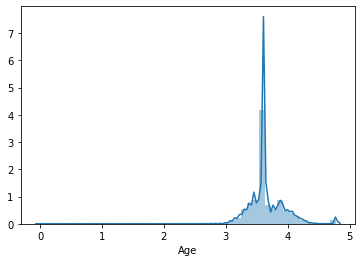

In [66]:
sns.distplot(df_train_logtransformed['Age'])
plt.show()

### Square root Transformation

In [67]:
df_train_sqrttransformed=pd.DataFrame() #Creating an empty Dataframe for storing Square root trnasformed values
for i in numerical_cols.columns:
    df_train_sqrttransformed[i]=np.sqrt(df_train[i])

C:\Users\mrityunjay1.pandey\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
df_train_sqrttransformed.skew()

Duration                2.052995
Net Sales               1.477936
Commision (in value)    1.194426
Age                     1.855245
dtype: float64

Since Skewness has not improved significently hence attempting Cube root.

### Cube root transformation

In [69]:
df_train_Qroot_ttransformed=pd.DataFrame() #Creating an empty Dataframe for storing Square root trnasformed values
for i in numerical_cols.columns:
    df_train_Qroot_ttransformed[i]=df_train[i]**(1/3)

In [70]:
df_train_Qroot_ttransformed.skew()

Duration                1.295924
Net Sales               0.525356
Commision (in value)    0.595859
Age                     1.476667
dtype: float64

Comparing three transformation results, it is evident log tranformation serves our purpose and approches closer to Gaussian Distribution.
Proceeding ahead with **"Log Transformed Data"**

### Outliers Detection

Plotting Box plot to check for outliers in the trnasformed data set.

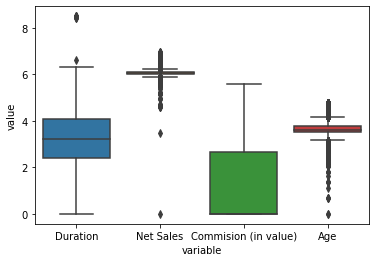

In [71]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_train_logtransformed))

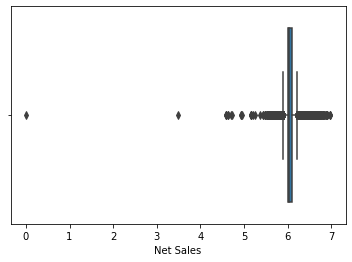

In [72]:
sns.boxplot(df_train_logtransformed['Net Sales'])

In [73]:
df_train_logtransformed['Net Sales'].describe()

count    52310.000000
mean         6.075546
std          0.123516
min          0.000000
25%          6.015669
50%          6.039064
75%          6.098074
max          6.977281
Name: Net Sales, dtype: float64

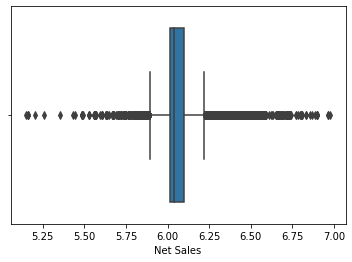

In [74]:
sns.boxplot(df_train_logtransformed['Net Sales'][df_train_logtransformed['Net Sales']>5])

In [75]:
df_train_logtransformed['Net Sales'][df_train_logtransformed['Net Sales']>6.5]

53       6.732509
74       6.524663
376      6.524663
378      6.677083
385      6.524663
           ...   
52027    6.659176
52069    6.583409
52184    6.570042
52253    6.567727
52305    6.727133
Name: Net Sales, Length: 644, dtype: float64

Above analysis suggests that there are outliers which needs treatmeant. Since number of data is more than 7K thus can't classify as outliers. Trying scaling techniques.

#### Scaling Data

In [76]:
ar_train_power=PowerTransformer(method='yeo-johnson').fit_transform(numerical_cols)

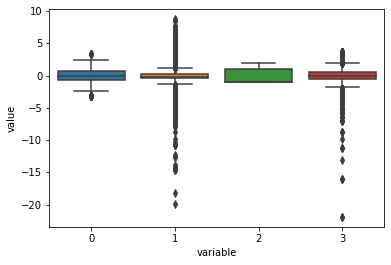

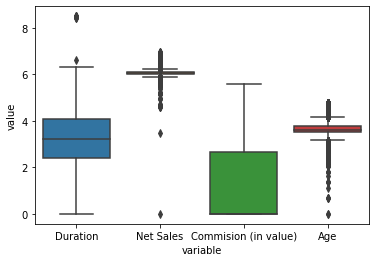

In [77]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame(ar_train_power)))
plt.show()
sns.boxplot(x="variable", y="value", data=pd.melt(df_train_logtransformed))

In [78]:
col_names=numerical_cols.columns #Getting column names for changing names in power transformed data
list(col_names)
df_train_power=pd.DataFrame(ar_train_power,columns=list(col_names))


In [79]:
df_train_power.head()

,Duration,Net Sales,Commision (in value),Age
0,0.725818,-0.600716,-0.949131,0.315168
1,-1.467900,-0.503455,-0.949131,-0.248013
2,0.063295,-0.450443,0.883540,0.785661
3,-0.383714,-0.317732,-0.949131,0.856913
4,-0.383714,-0.139885,-0.949131,-0.146309


###  Checking Correlation between Feature

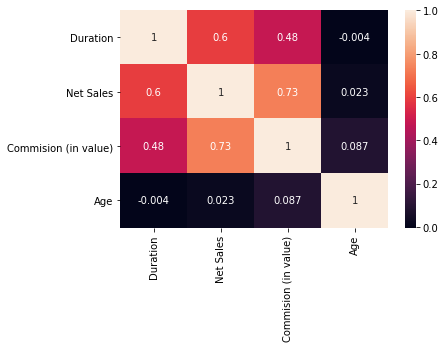

In [80]:
sns.heatmap(numerical_cols.corr(),annot=True)
plt.show()

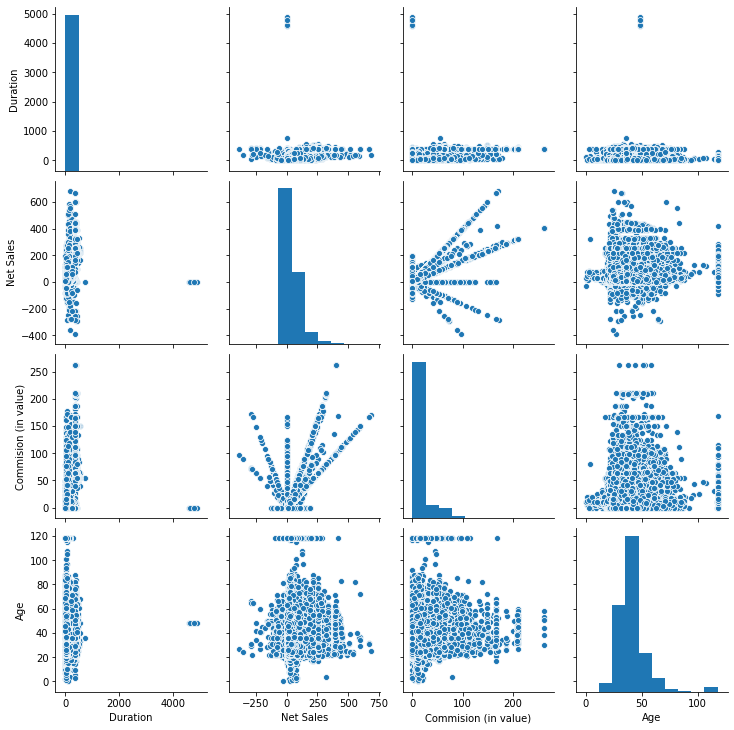

In [81]:
sns.pairplot(numerical_cols)

Heatmap & pairplot of correlation matrix above suggest there is correlation between "Net Sales" & "Commison", however they are not highly correlated hence **can't drop**.

All the numerical Features are independent in nature.

## Opeartion on Categorical Data

In [82]:
categorical_cols.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination'],
      dtype='object')

In [83]:
for i in categorical_cols:
    print("Column {} has {} unique values".format(i,len(categorical_cols[i].value_counts())))

Column Agency has 16 unique values
Column Agency Type has 2 unique values
Column Distribution Channel has 2 unique values
Column Product Name has 25 unique values
Column Destination has 97 unique values


Analysing above data it suggests columns **"Agency Type"** & **"Agency"** are of Boolean in nature.However rest 3 columns are of Non Boolean in nature hence opting for **LabelEncoding**.

In [84]:
le=preprocessing.LabelEncoder() #Intialising LabelEncoder Model
df_train_enc=pd.DataFrame() #Creating Empty Dataframe to store encoded Values
for i in (categorical_cols.columns): #Looping through to encode each columns
    df_train_enc[i] = le.fit_transform(df_train[i])

In [85]:
df_train_enc.head() #Checking for encoded values

,Agency,Agency Type,Distribution Channel,Product Name,Destination
0,7,1,1,10,68
1,7,1,1,10,53
2,6,1,1,16,84
3,7,1,1,1,33
4,7,1,1,1,53


Merging dataframes (Encoded +Tranformed)

In [86]:
df_train_cleaned=pd.concat([df_train_logtransformed,df_train_enc],axis=1) #Adding both dataframes

In [87]:
df_train_clean_power=pd.concat([df_train_power,df_train_enc],axis=1) #Adding both dataframes

In [102]:
df_train_cleaned.head()
#df_train_clean_power['Net Sales'].min()

,Duration,Net Sales,Commision (in value),Age,Agency,Agency Type,Distribution Channel,Product Name,Destination
0,4.127134,5.996452,0.000000,3.737670,7,1,1,10,68
1,1.609438,6.008813,0.000000,3.583519,7,1,1,10,53
2,3.295837,6.015669,2.555676,3.871201,6,1,1,16,84
3,2.772589,6.033086,0.000000,3.891820,7,1,1,1,33
4,2.772589,6.056784,0.000000,3.610918,7,1,1,1,53


### Applying Feature Selection Technique

Duration


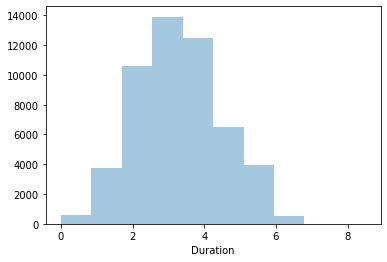

Net Sales


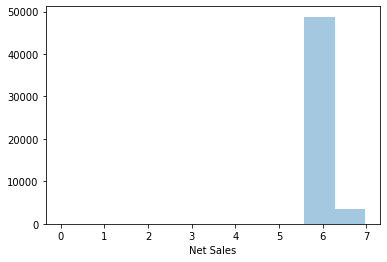

Commision (in value)


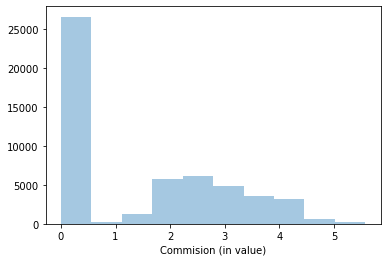

Age


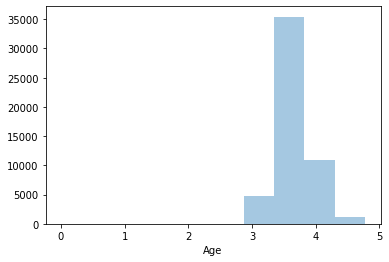

Agency


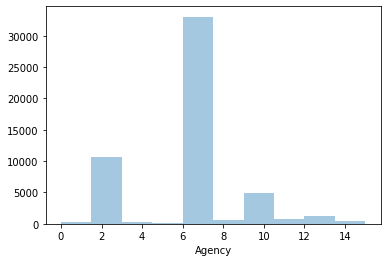

Agency Type


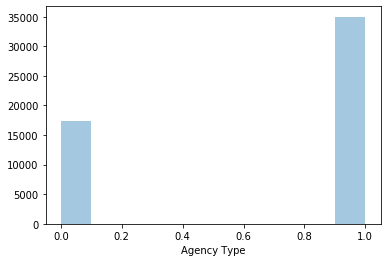

Distribution Channel


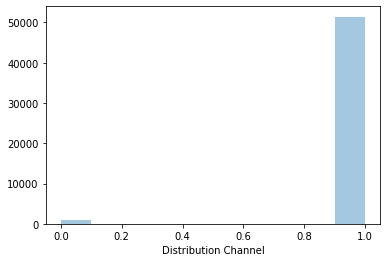

Product Name


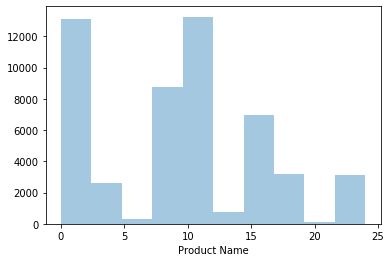

Destination


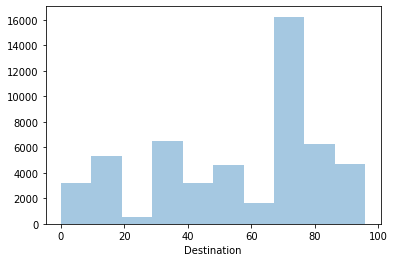

In [118]:
for i in df_train_cleaned.columns:
    print(i)
    sns.distplot(df_train_cleaned[i],bins=10,kde=False)
    plt.show()

In [116]:
df_train_cleaned['Distribution Channel'].value_counts()

1    51419
0      891
Name: Distribution Channel, dtype: int64

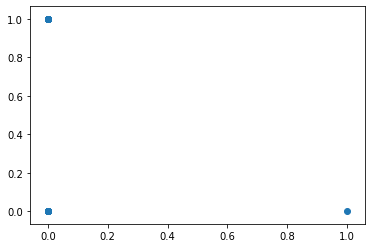

In [153]:
#df_train_cleaned[df_train_cleaned['Net Sales']>5] # 52298

#df_train_cleaned[df_train_cleaned['Net Sales']<5] # 12 out of 52310

plt.scatter(df_train_cleaned['Net Sales'],df_train.Claim)

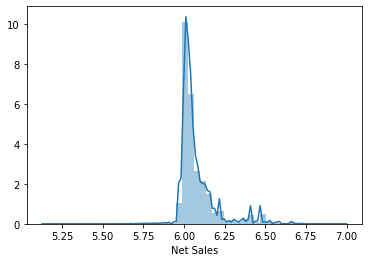

In [163]:
#df_train[df_train['Net Sales']<0]['Net Sales'].count()
sns.distplot(df_train_cleaned[df_train_cleaned['Net Sales']>5]['Net Sales'])

In [122]:
clean_skew=df_train_cleaned.skew()
log_skew=df_train_logtransformed.skew()
print(clean_skew,"+++++",log_skew)
df_train.skew()

Duration                0.319825
Net Sales              -0.798505
Commision (in value)    0.492381
Age                     0.764090
Agency                 -0.097111
Agency Type            -0.718350
Distribution Channel   -7.465242
Product Name            0.332685
Destination            -0.590582
dtype: float64 +++++ Duration                0.319825
Net Sales              -0.798505
Commision (in value)    0.492381
Age                     0.764090
dtype: float64


ID                      -0.001854
Duration                15.352563
Net Sales                2.811837
Commision (in value)     3.535694
Age                      2.947891
Claim                    1.788598
dtype: float64

## Model Building

### Splliting data in Feature and Target variable

In [41]:
#Data with Log Transformed
X=df_train_cleaned #Features
y=df_train['Claim'] #Target

In [42]:
#Power transformed data
X_power=df_train_clean_power #Features
y_power=df_train['Claim'] #Target

In [43]:
# Train Test Split Log Transformed Data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

In [44]:
# Train Test Split power Transformed Data
X_train,X_test,y_train,y_test=train_test_split(X_power,y_power,test_size=0.2,random_state=3)

In [45]:
#Checking for shape of Training data
print("Shape of X Train:",X_train.shape," & Y Train is ",y_train.shape)

Shape of X Train: (41848, 9)  & Y Train is  (41848,)


### Model Selection

#### LogisticRegression

**Note** Normalize your training data so that the problem hopefully becomes more well conditioned, which in turn can speed up convergence. One possibility is to scale your data to 0 mean, unit standard deviation using Scikit-Learn's StandardScaler for an example. Note that you have to apply the StandardScaler fitted on the training data to the test data.

In [46]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
lr_score=accuracy_score(y_test,y_pred)
lr_precision_score=precision_score(y_test,y_pred)

print("Accuracy Score is:{} & Precision Score is:{}".format(lr_score,lr_precision_score))

Accuracy Score is:0.8480214108201108 & Precision Score is:0.59472049689441


C:\Users\mrityunjay1.pandey\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Trying Decision Tree

In [47]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
dt_score=accuracy_score(y_test,y_pred)
dt_precision_score=precision_score(y_test,y_pred)

print("Accuracy Score is:{} & Precision Score is:{} for Decision Tree".format(dt_score,dt_precision_score))

Accuracy Score is:0.9174154081437583 & Precision Score is:0.7428407789232532 for Decision Tree


#### Trying Random Forest

In [48]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
rf_score=accuracy_score(y_test,y_pred)
rf_precision_score=precision_score(y_test,y_pred)

print("Accuracy Score is:{} & Precision Score is:{} for Random Forest".format(rf_score,rf_precision_score))

Accuracy Score is:0.9434142611355382 & Precision Score is:0.8504380475594493 for Random Forest


#### Trying XG Boost

In [49]:
xgb=XGBClassifier(base_estimator=rf,random_state=3)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
xgb_score=accuracy_score(y_test,y_pred)
xgb_precision_score=precision_score(y_test,y_pred)

print("Accuracy Score is:{} & Precision Score is:{} for Random Forest".format(xgb_score,xgb_precision_score))

[08:03:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { base_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy Score is:0.9276428981074364 & Precision Score is:0.8131147540983606 for Random Forest


## Queries:

1.Can commision be in negative or have value even if sales is 0?